# Pre-process NASA GWP data for use in the indicators
# TODO Clean this up, use it to run the scripts from population tools

- Reduce the resolution of the NASA population data to 1/8 of the , original to simplify and speed up analysis. Do this by summing the population total values from 4 adjacent grid squares, repeat 3 times.
- Reduce the resolution of the corresponding water mask to the same resoultion as the population data
- Linearly interpolate the 5-yearly NASA population data to each year and save as NetCDF file.
- Add the water mask to the NetCDF file.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from affine import Affine
from numba import jit
from rasterio import features
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.warp import reproject

import population_tools
from config import POP_DATA_SRC, DATA_SRC


In [2]:
N_ITERS_DEREZ = 3  # equivalent to 1/8th original resolution
REZ_FIX = 'eightres' # Set the resolution postfix name

POP_TYPE = 'count'
_POPULATION_PATH_TEMPLATE = 'population_{year}_{resolution}.tif'
_POP_SRC = POP_DATA_SRC / 'nasa_grid' / POP_TYPE
_POP_ORIGINAL_FOLDER_TMPL = 'gpw-v4-population-{type}-adjusted-to-2015-unwpp-country-totals-{year}'
_POP_ORIGINAL_TMPL = 'gpw-v4-population-{type}-adjusted-to-2015-unwpp-country-totals_{year}'

# TODO include derez of population files here

In [3]:
# TODO run the derez from here
# population_tools.do_derez(how='sum')
# population_tools.interp_to_netcdf()

# Reduce the resolution of the water mask file

In [5]:
def derez_water_mask(file_path, n_iters=1):
    """
    Load water mask and invert such that land is true and water is false
    Derez the water mask by performing 'or' of alternate rows
    and columns such that any point where one square is water (false)
    and the other square is land (true) the resulting point is considered as
    land, since the population may be non-zero.
    
    This is a bit fancier than just performing a decimated read 
    (https://mapbox.github.io/rasterio/topics/resampling.html)
    with the aim of avoiding dropping bits of the population
    """
    with rasterio.open(str(file_path)) as pop:
        print(pop.meta)
        pop_meta = pop.meta
        trns = pop.transform
        population = pop.read_masks(1)

        population = population.astype(bool)
    for i in range(n_iters):
        
        first = population[::2, :]
        second = population[1::2, :]
        if second.shape[0] < first.shape[0]:
            # missing a row, need to 'wrap'- just double the values from 'first' as an appoximation
            second = np.vstack((second, first[-1, :]))
        population = first | second
        # Sum every other column
        if second.shape[1] < first.shape[1]:
            # missing a row, need to 'wrap'- just double the values from 'first' as an appoximation
            second = np.hstack((second, first[:, -1]))
        first = population[:, ::2]
        second = population[:, 1::2]
        # population = population[:, ::2] + population[:, 1::2]
        population = first | second
        
        # Output affine scaled by 2
        trns = Affine(trns.a * 2, trns.b, trns.c, trns.d, trns.e * 2, trns.f)
        
    return population, trns, pop_meta



In [34]:
water_mask_input_file = POP_DATA_SRC / 'nasa_grid'/ 'gpw-v4-data-quality-indicators-water-mask' / 'gpw-v4-data-quality-indicators_water-mask.tif'

water_mask_file = POP_DATA_SRC / f'water_mask_{REZ_FIX}.tif'


In [ ]:
population, trns, pop_meta = derez_water_mask(water_mask_input_file, n_iters=4)
save_geotiff(population, trns, pop_meta)

# Combine the water mask with the population file

- TODO no need to store the water mask tif since we merge with the population netcdf, could add directly to the population file without saving intermediate TIF file

In [3]:
population_file = POP_DATA_SRC / f'population_count_2000-2020_{REZ_FIX}.nc'
water_mask_file = POP_DATA_SRC / 'nasa_grid' / f'water_mask_{REZ_FIX}.tif'

population_output_file = POP_DATA_SRC / f'population_count_2000-2020_{REZ_FIX}_new.nc'

In [1]:

def get_water_mask(target, file_path):
    """
    Get the water mask on 0-360 lon range

    Args:
        target:

    Returns:

    """

    with rasterio.open(str(file_path)) as pop:
        pop_mask = pop.read(1)


        new_mask = np.empty(shape=(len(target.latitude),
                                   len(target.longitude)))

        new_aff = get_affine(target)
        # Override xform to ensure -180 to 180 range
        transform = Affine(new_aff.a, 0, -180, 0, new_aff.e, new_aff.f)
        reproject(
            pop_mask, new_mask,
            src_transform=pop.transform,
            dst_transform=transform,
            src_crs=pop.crs,
            dst_crs=pop.crs,
            resample=Resampling.bilinear)

    # Roll to fix -180 to 180 vs 0 to 360 convention

    width = new_mask.shape[1]
    new_mask = np.roll(new_mask, -width // 2, axis=1)
    # TODO should this be as int or should we set 0 to nan
    new_mask[new_mask == 0] = np.nan
    return new_mask

In [4]:
pop = xr.open_dataset(population_file)
wat = get_water_mask(pop, water_mask_file)

In [6]:
pop['water_mask'] = xr.DataArray(wat, coords=[pop.latitude, pop.longitude])

In [7]:
pop.to_netcdf(population_output_file)

# Process new GPWv4 Netcdf to add intermediate years

In [26]:
pd.read_csv(POP_DATA_SRC / 'gpw_v4_netcdf_contents.csv')

,file_name,order,raster_name,raster_description
0,gpw_v4_e_atotpopbt_cntm,1,"Population Count, v4.10 (2000)",Population count for the year 2000
1,gpw_v4_e_atotpopbt_cntm,2,"Population Count, v4.10 (2005)",Population count for the year 2005
2,gpw_v4_e_atotpopbt_cntm,3,"Population Count, v4.10 (2010)",Population count for the year 2010
3,gpw_v4_e_atotpopbt_cntm,4,"Population Count, v4.10 (2015)",Population count for the year 2015
4,gpw_v4_e_atotpopbt_cntm,5,"Population Count, v4.10 (2020)",Population count for the year 2020
5,gpw_v4_e_atotpopbt_cntm,6,"Data Context, v4.10 (2010)",Categorizes pixels with estimated 0 population...
6,gpw_v4_e_atotpopbt_cntm,7,"Type of Tabular Input Data, v4.10",A code referencing the type of population data...
7,gpw_v4_e_atotpopbt_cntm,8,"Input Data Level, v4.10",Highest administrative level of input data used
8,gpw_v4_e_atotpopbt_cntm,9,"Input Data Year, v4.10",The year of the input population data used
9,gpw_v4_e_atotpopbt_cntm,10,"Growth Rate End Year, v4.10",The latest year used to calculate the annual e...


In [70]:
pop = xr.open_dataarray(POP_DATA_SRC /'gpw_v4_une_atotpopbt_cntm_30_min.nc')
pop.name = 'population'
width = len(pop.longitude)

In [73]:
# Select only the 1st 5 rasters which correspond to the year counts
pop = pop.sel(raster=[1,2,3,4,5])

In [74]:
pop = pop.roll(longitude=-width // 2)

In [75]:
pop['longitude'] = np.arange(0, 360, 0.5)

Convert raster number to year

In [76]:
pop['raster'] = 2000 + 5*(pop.raster-1)
pop = pop.rename({'raster':'year'})


In [77]:
pop['year'] = pop.year.astype(np.int32)

In [78]:
pop = pop.interp(year=(np.arange(2000, 2021)))

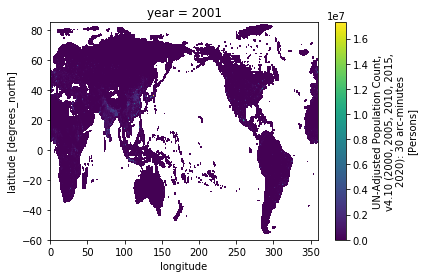

In [79]:
pop.sel(year=2001).plot()

In [81]:
pop.to_netcdf(POP_DATA_SRC / 'gpw_v4_population_count_2000-2020.nc')